In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import h2o
from h2o.automl import H2OAutoML

%matplotlib inline

In [2]:
# Enter the begin and end dates for the gage and flow data

begin_date = '2023-01-01T00:00:00.000-05:00'
end_date = '2024-08-12T00:00:00.000-05:00'

#01388500 - Pompton River at Route 23, Pompton Plains NJ

In [5]:
#Read in raw stream gage data
gage = pd.read_csv('https://nwis.waterservices.usgs.gov/nwis/iv/?sites=01388500&parameterCd=00065&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=27)
gage = gage.iloc[1: , :]

gage

,agency_cd,site_no,datetime,tz_cd,194446_00065,194446_00065_cd
1,USGS,01388500,2023-01-01 01:00,EST,9.37,A
2,USGS,01388500,2023-01-01 01:15,EST,9.37,A
3,USGS,01388500,2023-01-01 01:30,EST,9.37,A
4,USGS,01388500,2023-01-01 01:45,EST,9.37,A
5,USGS,01388500,2023-01-01 02:00,EST,9.38,A
...,...,...,...,...,...,...
56532,USGS,01388500,2024-08-12 00:00,EDT,9.49,P
56533,USGS,01388500,2024-08-12 00:15,EDT,9.49,P
56534,USGS,01388500,2024-08-12 00:30,EDT,9.48,P
56535,USGS,01388500,2024-08-12 00:45,EDT,9.48,P


In [6]:
gage['194446_00065'] = gage['194446_00065'].astype(float)
gage = gage[['datetime','194446_00065']]
gage = gage.set_index('datetime')
gage.head()

,194446_00065
datetime,
2023-01-01 01:00,9.37
2023-01-01 01:15,9.37
2023-01-01 01:30,9.37
2023-01-01 01:45,9.37
2023-01-01 02:00,9.38


In [8]:
#Read in raw flow data
flow = pd.read_csv('https://waterservices.usgs.gov/nwis/iv/?sites=01388500&parameterCd=00060&startDT='+begin_date+'&endDT='+end_date+'&siteStatus=all&format=rdb', sep='\t', skiprows=27)
flow = flow.iloc[1: , :]
flow

,agency_cd,site_no,datetime,tz_cd,194445_00060,194445_00060_cd
1,USGS,01388500,2023-01-01 01:00,EST,736,A
2,USGS,01388500,2023-01-01 01:15,EST,736,A
3,USGS,01388500,2023-01-01 01:30,EST,736,A
4,USGS,01388500,2023-01-01 01:45,EST,736,A
5,USGS,01388500,2023-01-01 02:00,EST,743,A
...,...,...,...,...,...,...
56533,USGS,01388500,2024-08-12 00:00,EDT,802,P
56534,USGS,01388500,2024-08-12 00:15,EDT,802,P
56535,USGS,01388500,2024-08-12 00:30,EDT,795,P
56536,USGS,01388500,2024-08-12 00:45,EDT,795,P


In [9]:
flow['194445_00060'] = flow['194445_00060'].astype(float)
flow = flow[['datetime','194445_00060']]
flow = flow.set_index('datetime')
flow.head()

,194445_00060
datetime,
2023-01-01 01:00,736.0
2023-01-01 01:15,736.0
2023-01-01 01:30,736.0
2023-01-01 01:45,736.0
2023-01-01 02:00,743.0


In [10]:
# Merge datasets together on datetime index and check if everything is good
df=pd.merge(gage, flow, how='inner', left_index=True, right_index=True)
df.head()

,194446_00065,194445_00060
datetime,,
2023-01-01 01:00,9.37,736.0
2023-01-01 01:15,9.37,736.0
2023-01-01 01:30,9.37,736.0
2023-01-01 01:45,9.37,736.0
2023-01-01 02:00,9.38,743.0


In [11]:
# Rename gage and flow rate colums to something humane and check the dataframe
df = df.rename(columns={"194446_00065": "Gage", "194445_00060": "Flow"  })
df.head()

,Gage,Flow
datetime,,
2023-01-01 01:00,9.37,736.0
2023-01-01 01:15,9.37,736.0
2023-01-01 01:30,9.37,736.0
2023-01-01 01:45,9.37,736.0
2023-01-01 02:00,9.38,743.0


In [12]:
#check the number of training rows
print('number of rows = ', df.shape[0])

number of rows =  56544


In [13]:
# Shift Gage readings by X time units and set as training label, calculate gage and flow rates of change 
def gage_forecast(df, forecast):
    df['Gage_forecast_'+str(forecast)] = df['Gage'].shift(-forecast)
    df['Gage_forecast_'+str(forecast_horizon)] = df['Gage_forecast_'+str(forecast_horizon)]
    df['Gage_diff'] = df['Gage'].shift(-1) - df['Gage']
    df['Flow_diff'] = df['Flow'].shift(-1) - df['Flow']
    df.drop(df.tail(forecast).index,inplace=True) # drop last n rows
    return df

In [14]:
# Set the forecast horizon. Note this is in time units, each time unit is 15 minutes. 
forecast_horizon = 12

In [15]:
# Process gage forecast and check results
df = gage_forecast(df, forecast_horizon)
df.tail(200)

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
datetime,,,,,
2024-08-09 20:15,10.49,1580.0,10.70,0.04,30.0
2024-08-09 20:30,10.53,1610.0,10.81,0.02,20.0
2024-08-09 20:45,10.55,1630.0,10.89,0.01,10.0
2024-08-09 21:00,10.56,1640.0,10.95,0.00,0.0
2024-08-09 21:15,10.56,1640.0,10.98,0.00,0.0
...,...,...,...,...,...
2024-08-11 21:00,9.56,853.0,9.49,-0.01,-7.0
2024-08-11 21:15,9.55,846.0,9.49,0.00,0.0
2024-08-11 21:30,9.55,846.0,9.48,-0.01,-8.0


In [16]:
#df.to_csv('data/checkgagediff.csv')

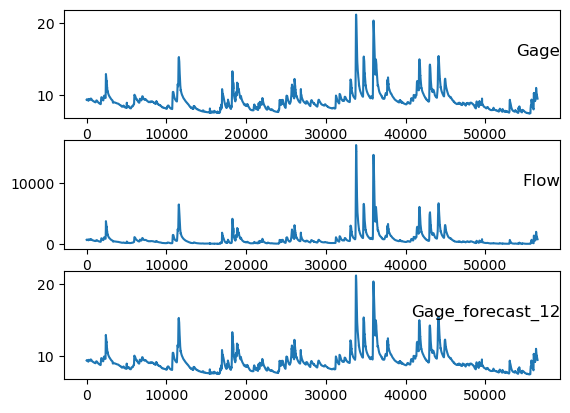

In [17]:
# Make a quick visual of stacked charts - this is a reality check
values = df.values
groups = [0,1,2,]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(df.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

Text(0, 0.5, 'Gage (ft)')

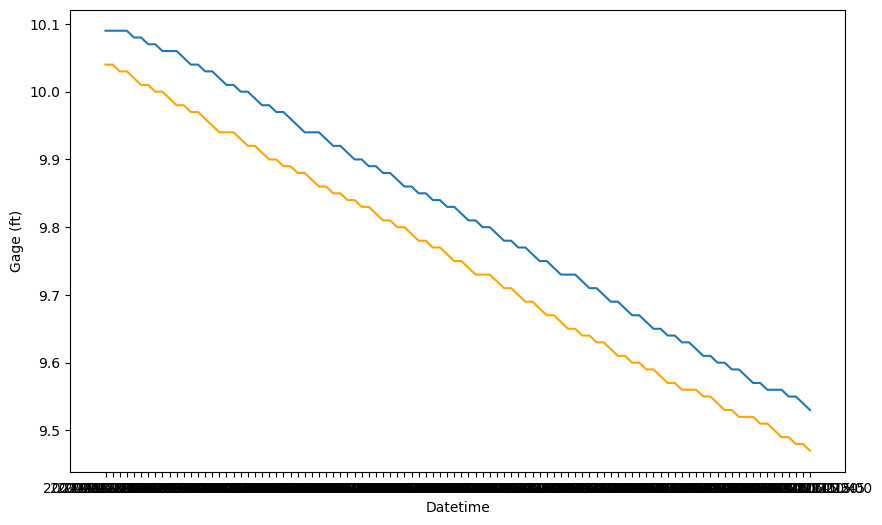

In [18]:
# Check if gage forecast is shifted from gage reading
plt.figure(figsize=(10,6))
plt.plot(df['Gage'].tail(100))
plt.plot(df['Gage_forecast_'+str(forecast_horizon)].tail(100), color = 'orange')
plt.xlabel('Datetime')
plt.ylabel('Gage (ft)')

In [19]:
#Split dataset into training and testing set
df.reset_index(drop=True,inplace=True)
df_train = df.loc[:int(df.shape[0]*0.8),:]
df_test = df.loc[int(df.shape[0]*0.8):,:]

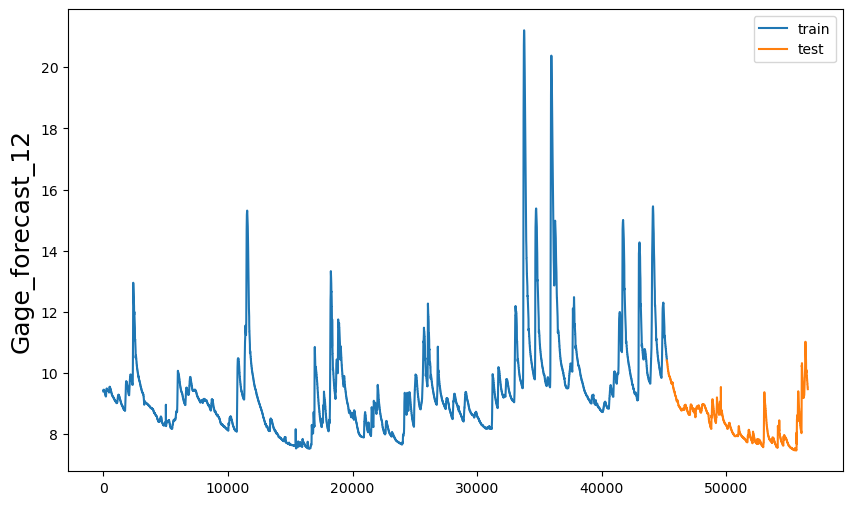

In [20]:
#Check dataset
plt.figure(figsize=(10,6))
plt.plot(df_train.index,df_train['Gage_forecast_'+str(forecast_horizon)])
plt.plot(df_test.index,df_test['Gage_forecast_'+str(forecast_horizon)])
plt.ylabel('Gage_forecast_'+str(forecast_horizon),fontsize=18)
plt.legend(['train','test'])
plt.show()

In [21]:
# Initialize H2O-3 on single node
h2o.init(nthreads=-1)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_411"; Java(TM) SE Runtime Environment (build 1.8.0_411-b09); Java HotSpot(TM) 64-Bit Server VM (build 25.411-b09, mixed mode)
  Starting server from /Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/39/8gc7tmt964lf1zccbqy781gm0000gp/T/tmplxl62k8q
  JVM stdout: /var/folders/39/8gc7tmt964lf1zccbqy781gm0000gp/T/tmplxl62k8q/h2o_tott_started_from_python.out
  JVM stderr: /var/folders/39/8gc7tmt964lf1zccbqy781gm0000gp/T/tmplxl62k8q/h2o_tott_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,04 secs
H2O_cluster_timezone:,America/Los_Angeles
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.44.0.3
H2O_cluster_version_age:,7 months and 24 days
H2O_cluster_name:,H2O_from_python_tott_lffzxw
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.541 Gb
H2O_cluster_total_cores:,10
H2O_cluster_allowed_cores:,10
H2O_cluster_status:,"locked, healthy"


In [22]:
# Load datesets into H2O frames
hf_train = h2o.H2OFrame(df_train)
hf_test = h2o.H2OFrame(df_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [23]:
# Check the dataset
hf_train.describe()

Rows:45226
Cols:5

,Gage,Flow,Gage_forecast_12,Gage_diff,Flow_diff
type,real,real,real,real,real
mins,7.53,86.7,7.53,-0.25,-210.0
mean,9.432641179852329,975.9743620926033,9.432921328439294,2.4101180736744335e-05,0.017998496440100778
maxs,21.21,16200.0,21.21,0.5099999999999998,530.0
sigma,1.5882579462188398,1446.9098795907598,1.5883419116781257,0.018717222305362723,19.427080031947572
zeros,0,0,0,31930,32602
missing,0,0,0,0,0
0,9.37,736.0,9.4,0.0,0.0
1,9.37,736.0,9.4,0.0,0.0
2,9.37,736.0,9.41,0.0,0.0


In [24]:
# Set up the independent variable 'y' and the dependent variables 'X'
#y = 'Gage_forecast_'+str(forecast_horizon)
y = 'Gage_forecast_'+str(forecast_horizon)
X = hf_train.columns
X.remove(y)

In [25]:
# List the columns for training, just for reality check
X

['Gage', 'Flow', 'Gage_diff', 'Flow_diff']

In [26]:
# Set up the H2O-3 AutoML model, run for 10 minutes with RSME as the stopping metric, use test set as validation set.
aml = H2OAutoML(max_runtime_secs = 1200,
                seed = 1234, stopping_metric = "RMSE", nfolds = 0,
                sort_metric = "RMSE")

aml.train(x = X, 
          y = y,
          training_frame = hf_train,
          validation_frame = hf_test, #leaderboard_frame
          )

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_1_20240814_114058


GLM Model: summary
    family    link      regularization               lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ----------------------------------------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 2.538E-4 )  nlambda = 30, lambda.max = 157.64, lambda.min = 2.538E-4, lambda.1se = -1.0  4                             4                              29                      AutoML_1_20240814_114058_training_Key_Frame__upload_80503512707a8968653f5c787b3d4141.hex

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.013637523899743367
RMSE: 0.11677980946954558
MAE: 0.04486937249689483
RMSLE: 0.009497859305252241
Mean Residual Deviance: 0.013637523899743367
R^2: 0.9945942353067129
Null degrees of freedom: 45225
Residual degrees of freedom: 45221
Null deviance: 114094.98764449471
Residual deviance: 616.7706558897935
AIC: -65884.68390371438

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 0.006428531472067686
RMSE: 0.08017812340076116
MAE: 0.03225558546447801
RMSLE: 0.008069647241347464
Mean Residual Deviance: 0.006428531472067686
R^2: 0.9861059235478568
Null degrees of freedom: 11306
Residual degrees of freedom: 11302
Null deviance: 16655.502694515733
Residual deviance: 72.68740535466932
AIC: -24966.656511476936

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train        deviance_test         alpha    iterations    training_rmse        training_deviance     training_mae         training_r2         validation_rmse      validation_deviance    validation_mae       validation_r2
---  -------------------  ----------  -----------  --------  ------------  --------------------  --------------------  -------  ------------  -------------------  --------------------  -------------------  ------------------  -------------------  ---------------------  -------------------  ------------------
     2024-08-14 11:41:02  0.000 sec   1            .16E3     5             2.462831215295654     1.4439371938835481    0.0
     2024-08-14 11:41:02  0.027 sec   2            .98E2     5             2.427321589748392     1.4266724076857344    0.0
     2024-08-14 11:41:02  0.050 sec   3            .61E2     5             2.371782038432929     1.3996178092240816    0.0
     2024-08-14 11:41:02  0.069 sec   4            .38E2     5             2.286385588682202     1.3578941024004836    0.0
     2024-08-14 11:41:02  0.098 sec   5            .23E2     5             2.1584551493707567    1.2950940502450266    0.0      5             0.11677980946954558  0.013637523899743367  0.04486937249689483  0.9945942353067129  0.08017812340076116  0.006428531472067686   0.03225558546447801  0.9861059235478568
     2024-08-14 11:41:02  0.114 sec   6            .15E2     5             1.974523098421422     1.2041053859711952    0.0
     2024-08-14 11:41:02  0.125 sec   7            .9E1      5             1.7255070532538934    1.0794180301037188    0.0
     2024-08-14 11:41:02  0.132 sec   8            .56E1     5             1.4158173672248984    0.9213440385772405    0.0
     2024-08-14 11:41:02  0.146 sec   9            .35E1     5             1.0723106766299826    0.7406681388048136    0.0
     2024-08-14 11:41:02  0.160 sec   10           .22E1     5             0.7415398886554422    0.5584424438278518    0.0
---  ---                  ---         ---          ---       ---           ---                   ---                   ---      ---           ---             

In [27]:
# Check leaderboard
lb = aml.leaderboard

lb

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
GLM_1_AutoML_1_20240814_114058,0.0801781,0.00642853,0.0322556,0.00806965,0.00642853
GBM_3_AutoML_1_20240814_114058,0.0805489,0.00648812,0.0330447,0.00815035,0.00648812
GBM_2_AutoML_1_20240814_114058,0.080685,0.00651007,0.0345051,0.00817452,0.00651007
XGBoost_grid_1_AutoML_1_20240814_114058_model_9,0.0811006,0.00657731,0.031609,0.00818239,0.00657731
GBM_4_AutoML_1_20240814_114058,0.0811219,0.00658077,0.0345738,0.00821525,0.00658077
XGBoost_grid_1_AutoML_1_20240814_114058_model_25,0.081378,0.00662238,0.034875,0.00817429,0.00662238
GBM_5_AutoML_1_20240814_114058,0.0819189,0.00671071,0.0331527,0.008259,0.00671071
XGBoost_grid_1_AutoML_1_20240814_114058_model_21,0.0821344,0.00674606,0.0388599,0.00824497,0.00674606
XGBoost_grid_1_AutoML_1_20240814_114058_model_5,0.0822241,0.00676081,0.0398934,0.00830248,0.00676081
XGBoost_1_AutoML_1_20240814_114058,0.0825721,0.00681815,0.0354544,0.00835368,0.00681815


In [28]:
# Select top model on LB as the winner
leader_model = aml.leader

In [29]:
hf_test_predict = leader_model.predict(hf_test)
hf_test_predict.head(5)

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


predict
10.4556
10.4556
10.3723
10.3624
10.4358


In [30]:
#contributions = leader_model.predict_contributions(hf_test)
#contributions

In [31]:
#staged_predict_proba = leader_model.staged_predict_proba(hf_test)

In [32]:
#staged_predict_proba

In [33]:
df_results = pd.DataFrame()
df_results['ground_truth'] = df_test['Gage'].reset_index(drop=True)
df_results['predictions'] = h2o.as_list(hf_test_predict,use_pandas=True)
df_results.tail()

/Users/tott/opt/anaconda3/envs/py310/lib/python3.10/site-packages/h2o/frame.py:1979: H2ODependencyWarning: converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above).
  warnings.warn("converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,ground_truth,predictions
11302,9.56,9.483741
11303,9.55,9.551356
11304,9.55,9.471894
11305,9.54,9.463863
11306,9.53,9.531479


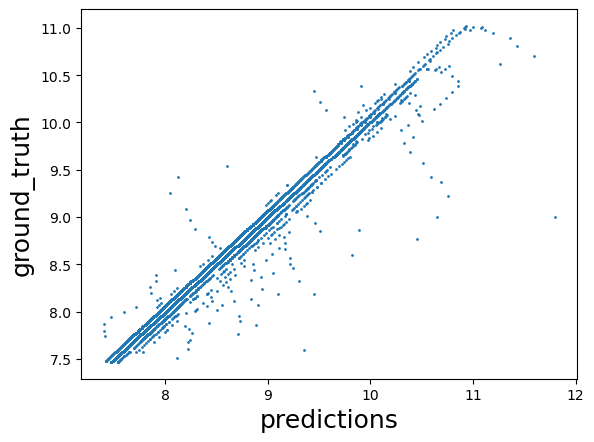

In [34]:
plt.scatter(x=df_results['predictions'],y=df_results['ground_truth'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

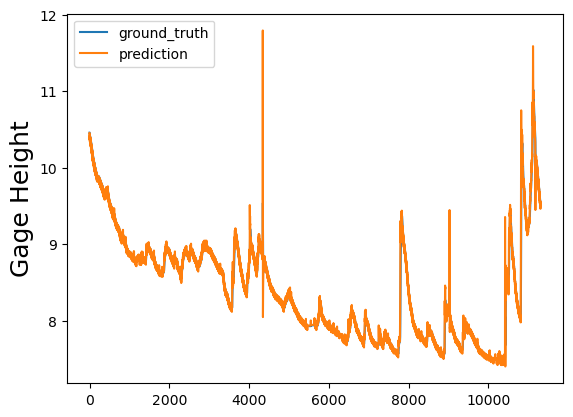

In [35]:
plt.plot(figsize=(20, 5))
plt.plot(df_results['ground_truth'])
plt.plot(df_results['predictions'])
plt.ylabel('Gage Height',fontsize=18)
plt.legend(['ground_truth','prediction'])
plt.show()

In [36]:
model_path = h2o.save_model(model=aml.leader, path="model/"+str(forecast_horizon)+"_time_units/", force=True)
print (model_path)

/Users/tott/Documents/GitHub/floodapp/model/12_time_units/GLM_1_AutoML_1_20240814_114058


In [37]:
load_model = h2o.load_model(model_path)
load_model.download_mojo(path="model/"+str(forecast_horizon)+"_time_units/")

'/Users/tott/Documents/GitHub/floodapp/model/12_time_units/GLM_1_AutoML_1_20240814_114058.zip'

In [38]:
#leader_model.explain(hf_test)

In [39]:
df_results['predictions'][:-48]

0        10.455605
1        10.455605
2        10.372335
3        10.362418
4        10.435773
           ...    
11254     9.756347
11255     9.829701
11256     9.746431
11257     9.736515
11258     9.809869
Name: predictions, Length: 11259, dtype: float64

In [40]:
print(aml.leader.rmse())

0.11677980946954558


In [41]:
h2o.cluster().shutdown()

H2O session _sid_b7af closed.
